# Implementación de Word2Vec (Softmax)


En primer lugar, definimos las funciones necesarias: para stemming y para indexar el vocabulario.





In [1]:
#-*- encoding:utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from nltk.stem.snowball import SnowballStemmer
from itertools import chain
from re import sub
from sklearn.decomposition import PCA
from operator import itemgetter

#Declaramos el stemeer
stemizer = SnowballStemmer('spanish')

#Funcion para stemming
def stems(string):
  stem_string = []
  for w in string.split():
    stem_string.append(stemizer.stem(w))
  return stem_string

#Funcion que crea un vocabulario de palabras con un indice numerico
def vocab():
    vocab = defaultdict()
    vocab.default_factory = lambda: len(vocab)
    return vocab    

#Funcion que pasa la cadena de simbolos a una secuencia con indices numericos
def text2numba(corpus, vocab):
    for doc in corpus:
        yield [vocab[w] for w in doc] #.split()]
  

Usamos Goolge Colab para cargar el corpus que vamos a analizar.

In [2]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
corpus = ['el perro come un hueso', 'un muchacho jugaba', 'el muchacho saltaba la cuerda',
          'un perro come croquetas', 'un muchacho juega']

#corpus = open('corpusML.txt','r', encoding='utf8').read().strip().split('\n')
#print(corpus[0])

Posteriormente, limpiamos y stemizamos el corpus. Asimismo, creamos el vocabulario con índices numéricos y transformamos las cadenas de palabras encadenas de índices numéricos. Se crean venanas de $1\times 1$

In [4]:
#Abrimos el documento, lo limpiamos y separamos las cadenas
#corpus = sub(r'[^\w\s]','',uploaded['corpus.es'].decode('utf8').strip().lower()).split('\n')
print(corpus[0])

#Stemizamos el documento
corpus = [sent.split() for sent in corpus] #[stems(sent) for sent in corpus]

#Llamamos la funcion para crear el vocabulario
idx = vocab()
#Creamos el vocabulario y le asignamos un indice a cada simbolo segun su aparicion
cads_idx = list(text2numba(corpus,idx))

print(corpus[0])
print(cads_idx[0])

el perro come un hueso
['el', 'perro', 'come', 'un', 'hueso']
[0, 1, 2, 3, 4]


In [5]:
cadenas = cads_idx 

#Se obtiene la longitud del alfabeto
N = len(idx)

print(cadenas[0])

[0, 1, 2, 3, 4]


Hecho esto, extraemos los bigramas del texto.

In [6]:
#Se crean los bigramas
contexts = list(chain(*[zip(cad,cad[1:]) for cad in cadenas])) + list(chain(*[zip(cad[1:],cad) for cad in cadenas]))

#Se obtiene la frecuencia de cada bigrama
frecContexts = Counter(contexts)

print(contexts)

[(0, 1), (1, 2), (2, 3), (3, 4), (3, 5), (5, 6), (0, 5), (5, 7), (7, 8), (8, 9), (3, 1), (1, 2), (2, 10), (3, 5), (5, 11), (1, 0), (2, 1), (3, 2), (4, 3), (5, 3), (6, 5), (5, 0), (7, 5), (8, 7), (9, 8), (1, 3), (2, 1), (10, 2), (5, 3), (11, 5)]


Ahora, paamos a la rd neuronla.
Primero, inicializamos los parámetros de la red. Requerimos de dos matrices U (la matriz de embedding) y W (la matriz de la capa de salida).

In [7]:
np.random.seed(0)
#El número de rasgos que representan cada vector
nn_input_dim = N
#El total de clases que arrojará
output_dim = N
#El número de ejmplos
num_examples = len(contexts)

#Dimensiones de los vectores-palabra
dim = 2

#Embedding
C = np.random.randn(dim, N) / np.sqrt(N)

#Capa de salida
W = np.random.randn(N,dim) / np.sqrt(dim) #N-1

print(C.shape)
print(W.shape)

(2, 12)
(12, 2)


Ahora entrenamos la red con el algoritmo de backpropagation y de gradiente descendiente.

In [8]:
its = 100
eta = 0.1
for i in range(0,its):
    for ex in contexts:
        #Forward
        #Embedimiento
        u_w = C.T[ex[0]]
        #salida
        a = np.dot(W,u_w)
        out = np.exp(a - np.max(a))
        #Softmax
        f = out/out.sum(0)

        #Backprop
        #Variable de salida
        d_out = f
        d_out[ex[1]] -= 1
        
        #Variable de embedding
        d_emb = np.dot(d_out,W)
        
        #Actualizacion de salida
        W -= eta*np.outer(d_out,u_w)

        #Actualizacion de embedding
        C.T[ex[0]] -= eta*d_emb
        
    print('Fin de la iteración',i)

Fin de la iteración 0
Fin de la iteración 1
Fin de la iteración 2
Fin de la iteración 3
Fin de la iteración 4
Fin de la iteración 5
Fin de la iteración 6
Fin de la iteración 7
Fin de la iteración 8
Fin de la iteración 9
Fin de la iteración 10
Fin de la iteración 11
Fin de la iteración 12
Fin de la iteración 13
Fin de la iteración 14
Fin de la iteración 15
Fin de la iteración 16
Fin de la iteración 17
Fin de la iteración 18
Fin de la iteración 19
Fin de la iteración 20
Fin de la iteración 21
Fin de la iteración 22
Fin de la iteración 23
Fin de la iteración 24
Fin de la iteración 25
Fin de la iteración 26
Fin de la iteración 27
Fin de la iteración 28
Fin de la iteración 29
Fin de la iteración 30
Fin de la iteración 31
Fin de la iteración 32
Fin de la iteración 33
Fin de la iteración 34
Fin de la iteración 35
Fin de la iteración 36
Fin de la iteración 37
Fin de la iteración 38
Fin de la iteración 39
Fin de la iteración 40
Fin de la iteración 41
Fin de la iteración 42
Fin de la iteración 4

Entrenada la red, definimos una función forward para obtener las probabilidades a partir de la red ya entrenada.

In [9]:
#Forward
def forward(x):    
    #Embedimiento
    u_w = C.T[x]
    #Capa de salida
    out = np.exp(np.dot(W,u_w))
    p = out/out.sum(0)
    return p

Podemos probar cómo son las probabilidades de la red. En este caso, lo hacemos para el símbolo BOS.

In [10]:
for word in idx.keys():
  #if word != '<BOS>':
    print(word,forward(idx['perro'])[idx[word]])

el 0.17213392176111833
perro 0.019557189586549246
come 0.2917201888758483
un 0.4703867576034756
hueso 0.002172033986129515
muchacho 9.411339964002535e-05
jugaba 0.01064221121408161
saltaba 0.00023415462914648438
la 2.182984223135465e-06
cuerda 2.1010696520820872e-05
croquetas 0.030784356366616146
juega 0.0022518788966506427


## Vectores distribuidos

Los vectores de word embeddings se almacenan en la matriz de la capa de embedding (capa oculta). De esta forma, cada columna de la matriz corresponde a un vector que representa una palabra.

In [11]:
pd.DataFrame(data=C.T, index=list(idx.keys()))

,0,1
el,1.863235,-1.764329
perro,1.746232,1.212239
come,0.874251,-0.171030
un,0.872842,-0.636562
hueso,1.175048,3.173256
muchacho,0.025719,1.653847
jugaba,0.813070,-2.609903
saltaba,-0.440485,-1.733584
la,-2.127755,0.697454
cuerda,-1.984458,-1.826014


Podemos, entonces, visualizar los datos en un espacio vectorial.

In [12]:
def plot_words(Z,ids):
    Z = PCA(2).fit_transform(Z)
    r=0
    plt.scatter(Z[:,0],Z[:,1], marker='o', c='blue')
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
    plt.show()

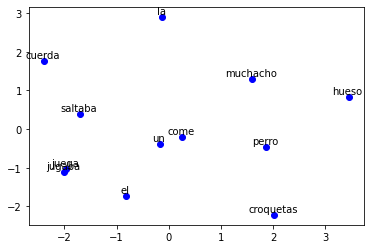

In [13]:
plot_words(C.T, list(idx.keys()))